In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from pycaret.classification import *
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
dtype_dict = {
    'spec_B': str,
    'spec_T': str,
    'spkid': int,
    'full_name': str,
    'name': str
    # Add other column mappings as necessary
}
df1 = pd.read_csv("data/spec.csv", dtype=dtype_dict)
df1 = df1[df1['spec_T'].notna()]
df1 = df1.drop(['spec_B', 'spkid', 'full_name'], axis=1)
df1 = df1[df1["name"].notna()]

In [6]:
dtype_dict = {
    'pdes': str,
    'name': str,
    'prefix': str,
    'neo': str
}
df2 = pd.read_csv("data/ast_info.csv", dtype = dtype_dict)
df2 = df2.drop(["id", "full_name", "pdes", "prefix", 'spkid'], axis=1)
df2 = df2[df2["name"].notna()]
df2['neo'] = df2['neo'].replace({'Y': 1, 'N': 0})

In [7]:
merged_df = pd.merge(df1, df2, on='name', how='inner')

In [8]:
# Define the list of useful columns for Tholen class prediction
useful_columns = [
    'H',           # Absolute Magnitude
    'albedo',      # Reflectivity
    'diameter',    # Object Diameter
    'i',           # Inclination
    'a',           # Semi-major Axis
    'q',           # Perihelion Distance
    'e',           # Eccentricity
    'neo',
    'spec_T'          # Near-Earth Object Flag
]

# Filter the DataFrame to keep only the useful columns
merged_df = merged_df[useful_columns]
df = merged_df

In [9]:
asteroid_data = {
    "composition": ['G', 'B', 'S', 'V', 'C', 'M', 'E', 'FC', 'P', 'CG', 'X', 'CU', 
       'CF', 'XC', 'CP', 'BU', 'TDG', 'MU', 'T', 'GC', 'DCX', 'ST', 'CX',
       'SU', 'SR', 'CPF', 'F', 'GU', 'I', 'XFC', 'STU', 'CD', 'GC:', 'C:',
       'XC:', 'DCX:', 'BCU', 'A', 'SCTU', 'CX:', 'DU', 'PC', 'D', 'BFU::',
       'CXF', 'FP', 'CSGU', 'R', 'DP', 'QSV', 'BFC', 'PD', 'DT', 'DX',
       'F:', 'X:', 'TD', 'CSU', 'CB', 'FCX', 'FXU:', 'CGU', 'DU:', 'XD:',
       'XCU', 'CDX:', 'CFB:', 'XDC', 'PCD', 'TSD', 'FCX:', 'XB:', 'SD',
       'CD:', 'CP:', 'DX:', 'STGD', 'CGSU', 'FX:', 'XF', 'SC', 'CPU:',
       'XD', 'DXCU', 'XFU', 'GS:', 'CBU:', 'CTGU:', 'FCB', 'XB', 'DTU',
       'CB:', 'FC:', 'FU', 'PF', 'CFU:', 'XSC', 'DTU:', 'CGTP:', 'FCU',
       'MU:', 'PDC', 'BC:', 'FX', 'XU', 'BCF', 'P:', 'PU', 'XSCU', 'AS',
       'G:', 'CBU', 'FBCU::', 'AU:', 'XFCU', 'Q', 'SQ', 'SMU', 'BU:',
       'TCG:', 'DSU:', 'CFXU', 'SG', 'BCU:', 'EU', 'SDU::', 'BFX', 'QRS',
       'TS', 'Z']
}

# Define mapping for each type
other_types = {'C', 'G', 'B', 'F', 'P', 'D', 'G:', 'C:', 'CG', 'CGU', 'CB', 'CB:', 'FC', 'FC:', 'BC', 'BC:', 'CP', 'CPF', 'PC', 'DCX', 'CD', 'CDX:', 'FCU', 'FCB', 'S', 'SU', 'SR', 'SQ', 'ST', 'SC', 'SCU', 'CSU', 'SD', 'SDU::', 'TS', 'STU', 'SCTU', 'AS'}
m_types = {'M', 'MU', 'MU:', 'E', 'X', 'XF', 'XFC', 'XCU', 'XU', 'XSC', 'XSCU'}

# Function to map composition to spec_T
def map_spec_type(comp):
    if comp in other_types:
        return 'Other'
    elif comp in m_types:
        return 'M'
    else:
        return None

# Apply the mapping
df["spec_T"] = df["spec_T"].apply(map_spec_type)

# Filter out rows where spec_T is None (i.e., mixed or unmapped types)
merged_df = df.dropna()

In [10]:
Counter(merged_df["spec_T"])

Counter({'Other': 664, 'M': 113})

In [13]:
X = merged_df.drop(["spec_T"], axis=1)
y = merged_df["spec_T"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [15]:
smote = SMOTE(sampling_strategy={'Other': max(Counter(y_train).values()),
                                 'M': max(Counter(y_train).values())},
              random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler

train_neo = X_train["neo"]
test_neo = X_test["neo"]

# Drop the "neo" column for scaling
train_features = X_train.drop(columns=["neo"])
test_features = X_test.drop(columns=["neo"])

# Apply Standard Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

# Convert back to DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_features.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_features.columns)

# Add the "neo" column back
X_train["neo"] = train_neo.values
X_test["neo"] = test_neo.values

In [17]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
X_train.head()

,H,albedo,diameter,i,a,q,e,neo
0,8.9,0.048,103.402,2.103207,2.589529,2.314048,0.106383,0.0
1,8.3,0.228,56.309,6.028907,2.421378,1.973064,0.185148,0.0
2,7.4,0.042,216.000,15.944369,3.125473,2.799548,0.104280,0.0
3,10.7,0.271,17.016,1.041052,2.599438,2.200516,0.153465,0.0
4,9.2,0.206,40.056,1.745234,2.892842,2.858379,0.011913,0.0


In [19]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']  # Replace 'auto' with None
}

clf = RandomForestClassifier(random_state=0)
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [20]:
y_pred = random_search.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.8365758754863813

In [23]:
cm = confusion_matrix(y_test, y_pred)

<Axes: >

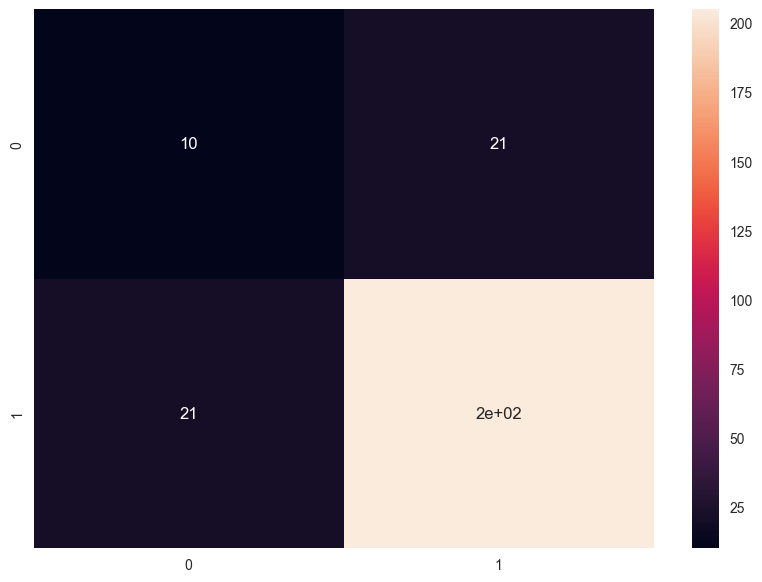

In [24]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.32      0.32      0.32        31
       Other       0.91      0.91      0.91       226

    accuracy                           0.84       257
   macro avg       0.61      0.61      0.61       257
weighted avg       0.84      0.84      0.84       257



In [26]:
from xgboost import XGBClassifier

In [71]:
mapping = {'M': 0, 'Other': 1}
y_train_mapped = y_train.map(mapping)
y_test_mapped = y_test.map(mapping)

In [81]:
xgb_model = XGBClassifier()

#Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=10,  # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train_mapped)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


<Axes: >

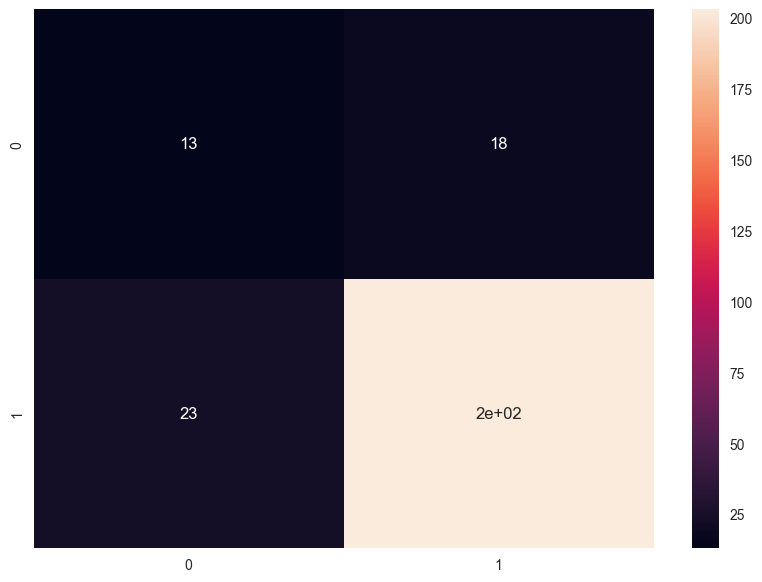

In [82]:
cm = confusion_matrix(y_test_mapped, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [77]:
accuracy_score(y_test_mapped, y_pred)

0.8404669260700389

In [78]:
print(classification_report(y_test_mapped, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.42      0.39        31
           1       0.92      0.90      0.91       226

    accuracy                           0.84       257
   macro avg       0.64      0.66      0.65       257
weighted avg       0.85      0.84      0.85       257



In [32]:
knn = KNeighborsClassifier()

# Step 4: Define the hyperparameter search space
param_dist = {
    'n_neighbors': np.arange(1, 31),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Step 5: Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    knn, 
    param_distributions=param_dist, 
    n_iter=50,  # Number of random samples
    scoring='accuracy', 
    cv=5,  # 5-fold cross-validation
    random_state=42, 
    n_jobs=-1  # Use all available cores
)

# Step 6: Fit the model to the training data
random_search.fit(X_train, y_train)
best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

<Axes: >

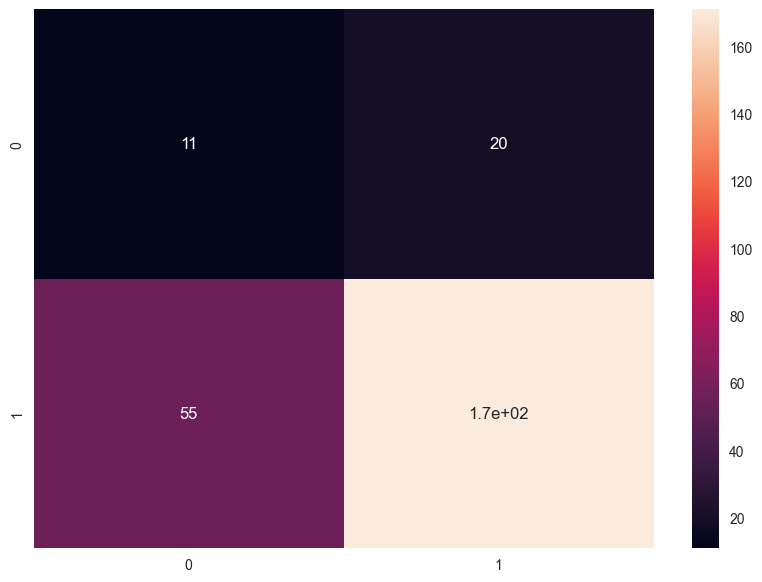

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [34]:
accuracy_score(y_test, y_pred)

0.708171206225681

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.17      0.35      0.23        31
       Other       0.90      0.76      0.82       226

    accuracy                           0.71       257
   macro avg       0.53      0.56      0.52       257
weighted avg       0.81      0.71      0.75       257



In [36]:
merged_df.head()

,H,albedo,diameter,i,a,q,e,neo,spec_T
0,3.40,0.0900,939.400,10.594067,2.769165,2.558684,0.076009,0.0,Other
1,4.20,0.1010,545.000,34.832932,2.773841,2.135935,0.229972,0.0,Other
2,5.33,0.2140,246.596,12.991043,2.668285,1.982706,0.256936,0.0,Other
4,6.90,0.2740,106.699,5.367427,2.574037,2.082619,0.190913,0.0,Other
5,5.80,0.2679,185.180,14.739653,2.424533,1.931822,0.203219,0.0,Other


In [37]:
clf_setup = setup(
    data=merged_df, 
    target='spec_T',  # Replace with your target column
    session_id=123,  # For reproducibility
    normalize=True,  # Normalize features
    feature_selection=True,  # Enable automatic feature selection
)

,Description,Value
0,Session id,123
1,Target,spec_T
2,Target type,Binary
3,Target mapping,"M: 0, Other: 1"
4,Original data shape,"(777, 9)"
5,Transformed data shape,"(777, 2)"
6,Transformed train set shape,"(543, 2)"
7,Transformed test set shape,"(234, 2)"
8,Numeric features,8
9,Preprocess,True


In [38]:
best = clf_setup.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8656,0.4694,0.8656,0.8018,0.8174,0.1517,0.1899,0.0770
qda,Quadratic Discriminant Analysis,0.8656,0.4683,0.8656,0.8018,0.8174,0.1517,0.1899,0.0700
lda,Linear Discriminant Analysis,0.8600,0.5006,0.8600,0.7785,0.7997,0.0588,0.0989,0.0670
lightgbm,Light Gradient Boosting Machine,0.8600,0.6016,0.8600,0.8252,0.8274,0.2192,0.2582,0.1230
lr,Logistic Regression,0.8564,0.5006,0.8564,0.7464,0.7916,0.0196,0.0329,0.3700
xgboost,Extreme Gradient Boosting,0.8564,0.5938,0.8564,0.8187,0.8243,0.2045,0.2347,0.0760
ridge,Ridge Classifier,0.8545,0.5006,0.8545,0.7302,0.7875,0.0000,0.0000,0.0960
dummy,Dummy Classifier,0.8545,0.5000,0.8545,0.7302,0.7875,0.0000,0.0000,0.0630
ada,Ada Boost Classifier,0.8527,0.5931,0.8527,0.7938,0.8051,0.1015,0.1393,0.1050
knn,K Neighbors Classifier,0.8471,0.5430,0.8471,0.8104,0.8152,0.1666,0.1960,0.0890


In [39]:
import lightgbm as lgb

In [57]:
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Step 3: Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 100],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Step 4: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Step 5: Perform the search
random_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 438, number of negative: 438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1786
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [58]:
accuracy

0.8326848249027238

<Axes: >

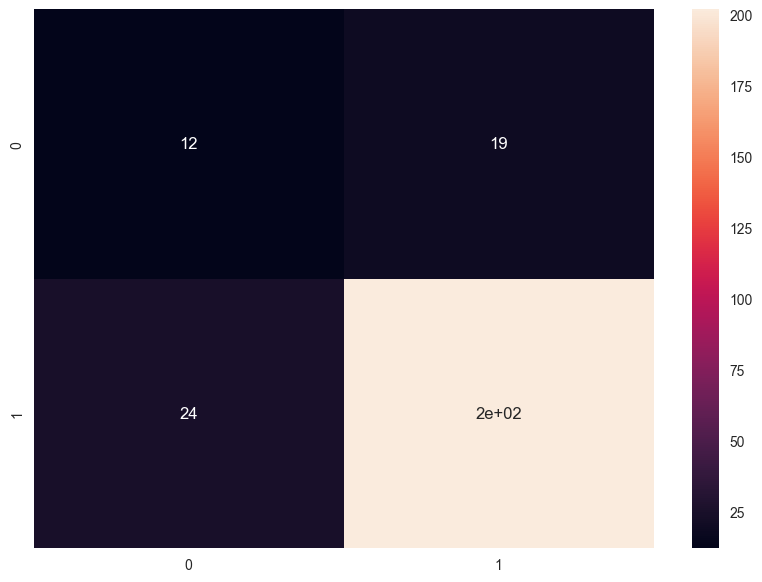

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.33      0.39      0.36        31
       Other       0.91      0.89      0.90       226

    accuracy                           0.83       257
   macro avg       0.62      0.64      0.63       257
weighted avg       0.84      0.83      0.84       257



In [45]:
gnb = GaussianNB()

In [49]:
param_distributions = {
    "var_smoothing": np.logspace(-10, -1, 100)  # Range of values for variance smoothing
}

# 4. Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=gnb,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to try
    scoring="recall",
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# 5. Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

<Axes: >

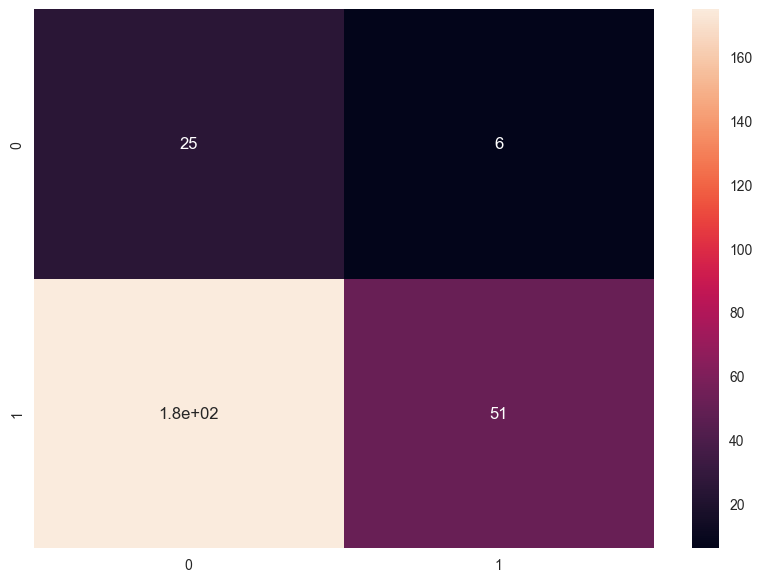

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Define SVM and Hyperparameter Space
svm = SVC()
param_distributions = {
    'C': np.logspace(-3, 3, 10),  # Logarithmic scale for C
    'gamma': np.logspace(-3, 3, 10),  # Logarithmic scale for gamma
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'degree': [2, 3, 4],  # For polynomial kernel
}

# 5. Randomized Search
random_search = RandomizedSearchCV(
    svm, 
    param_distributions, 
    n_iter=50,  # Number of parameter combinations to try
    scoring='accuracy', 
    cv=5,  # 5-fold cross-validation
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

# 6. Evaluate Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


<Axes: >

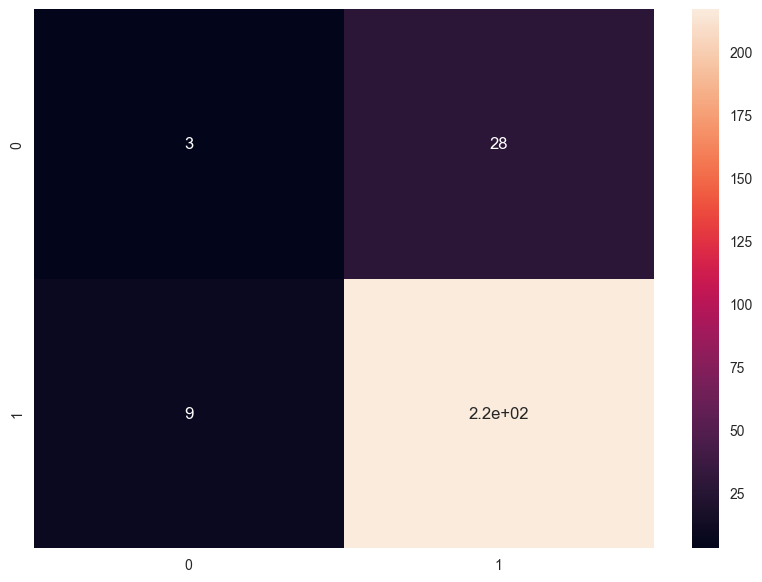

In [64]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [63]:
accuracy_score(y_test, y_pred)

0.8560311284046692

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.25      0.10      0.14        31
       Other       0.89      0.96      0.92       226

    accuracy                           0.86       257
   macro avg       0.57      0.53      0.53       257
weighted avg       0.81      0.86      0.83       257



In [67]:
from scipy.stats import randint
model = DecisionTreeClassifier(random_state=42)

# Step 5: Set hyperparameter distributions
param_distributions = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Step 6: Perform randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

# Step 7: Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


<Axes: >

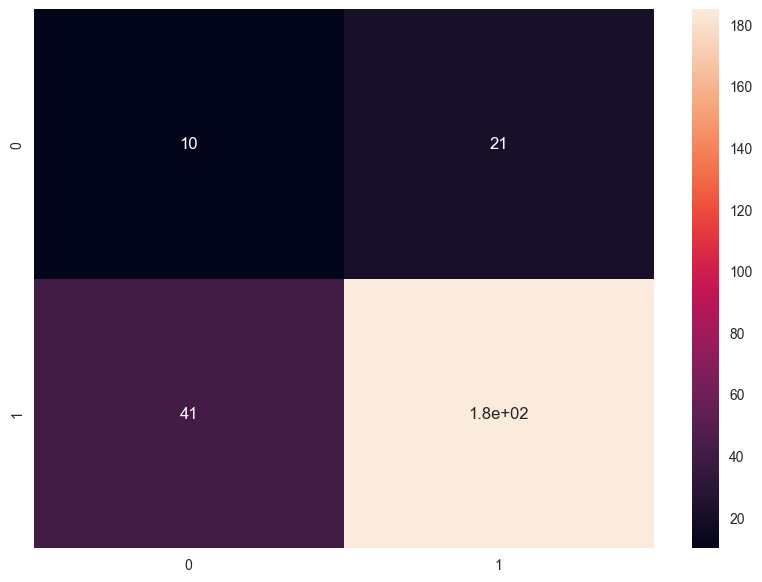

In [68]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)